In [1]:
#!pip install wandb
import numpy as np
import tensorflow as tf
from tensorflow import keras
#import wandb
#from wandb.keras import WandbCallback


In [2]:

num_samples = 100000  # Number of samples to train on.
from google.colab import drive
drive.mount('/content/drive')

# Path to the data txt file on google drive.

data_path = "/content/drive/My Drive/lexicons/hi.translit.sampled.train.tsv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Vectorize the data.


input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    input_text = "\t" + input_text + " " + "\n" 
    target_text = "\t" + target_text + " " + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)

    



In [4]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time



def preprocess_sentence(w):

  w = w.strip()
  k=''
  for i in w:
    k=k+' '+ i


  w = '<start> ' + k + ' <end>'
  return w

In [5]:


#Preprocessing the input and output
hii=input_texts
eni=target_texts
en=[]
hi=[]
for i in eni:
  en.append(preprocess_sentence(i))
print(en[:10])
for i in hii:
  hi.append(preprocess_sentence(i))


print(hi[:10])


['<start>  a n <end>', '<start>  a n k g a n i t <end>', '<start>  u n c l e <end>', '<start>  a n k u r <end>', '<start>  a n k u r a n <end>', '<start>  a n k u r i t <end>', '<start>  a a n k u s h <end>', '<start>  a n k u s h <end>', '<start>  a n g <end>', '<start>  a n g a <end>']
['<start>  अ ं <end>', '<start>  अ ं क ग ण ि त <end>', '<start>  अ ं क ल <end>', '<start>  अ ं क ु र <end>', '<start>  अ ं क ु र ण <end>', '<start>  अ ं क ु र ि त <end>', '<start>  अ ं क ु श <end>', '<start>  अ ं क ु श <end>', '<start>  अ ं ग <end>', '<start>  अ ं ग <end>']


In [6]:
#vectorizing the input and output
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer
input_tensor, inp_lang = tokenize(hi)
target_tensor, targ_lang = tokenize(en)

In [7]:
#Getting the max length
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]


In [8]:
#Spliting the data
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))


35363 35363 8841 8841


In [9]:
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print(f'{t} ----> {lang.index_word[t]}')

In [10]:
#Printing the vector
print("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[1])
print()
print("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[1])

Input Language; index to word mapping
1 ----> <start>
4 ----> र
19 ----> ो
16 ----> व
4 ----> र
2 ----> <end>

Target Language; index to word mapping
2 ----> <start>
7 ----> r
11 ----> o
19 ----> v
10 ----> e
7 ----> r
3 ----> <end>


In [11]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [12]:
#Encoder class
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [13]:
#encoder object
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)



In [14]:
#Attention class
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [16]:
#Attention object with 10 units
attention_layer = BahdanauAttention(10)


In [17]:
#Decoder class
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [18]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)



In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [21]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [22]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)

  print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
  print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.2556
Epoch 1 Batch 100 Loss 0.8807
Epoch 1 Batch 200 Loss 0.4637
Epoch 1 Batch 300 Loss 0.2286
Epoch 1 Batch 400 Loss 0.2454
Epoch 1 Batch 500 Loss 0.1920
Epoch 1 Loss 0.4630
Time taken for 1 epoch 67.38 sec

Epoch 2 Batch 0 Loss 0.1903
Epoch 2 Batch 100 Loss 0.1777
Epoch 2 Batch 200 Loss 0.1694
Epoch 2 Batch 300 Loss 0.1520
Epoch 2 Batch 400 Loss 0.2151
Epoch 2 Batch 500 Loss 0.1340
Epoch 2 Loss 0.1729
Time taken for 1 epoch 50.31 sec

Epoch 3 Batch 0 Loss 0.1488
Epoch 3 Batch 100 Loss 0.2569
Epoch 3 Batch 200 Loss 0.1900
Epoch 3 Batch 300 Loss 0.1339
Epoch 3 Batch 400 Loss 0.1367
Epoch 3 Batch 500 Loss 0.1589
Epoch 3 Loss 0.1780
Time taken for 1 epoch 49.94 sec

Epoch 4 Batch 0 Loss 0.1094
Epoch 4 Batch 100 Loss 0.1174
Epoch 4 Batch 200 Loss 0.1167
Epoch 4 Batch 300 Loss 0.1363
Epoch 4 Batch 400 Loss 0.1937
Epoch 4 Batch 500 Loss 0.1493
Epoch 4 Loss 0.1439
Time taken for 1 epoch 50.26 sec

Epoch 5 Batch 0 Loss 0.1148
Epoch 5 Batch 100 Loss 0.1343
Epoch 5 Batch 

In [23]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  #inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs=[]
  for i in sentence.split(' '):
    if i in inp_lang.word_index:
      inputs.append(inp_lang.word_index[i])
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [28]:
!pip install fonttools

from matplotlib.font_manager import FontProperties


#using hindi font for display

def plot_attention(attention, sentence, predicted_sentence):
  nirm = "/content/drive/My Drive/lexicons/ARIALUNI.TTF"
  prop = FontProperties(fname=nirm)

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence,  rotation=90,fontproperties=prop)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [29]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input:', sentence)
  print('Predicted translation:', result)

  attention_plot = attention_plot[:len(result.split(' ')),
                                  :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start>  अ ं ग ् र ज ़ ी <end>
Predicted translation: a n g r a j i <end> 


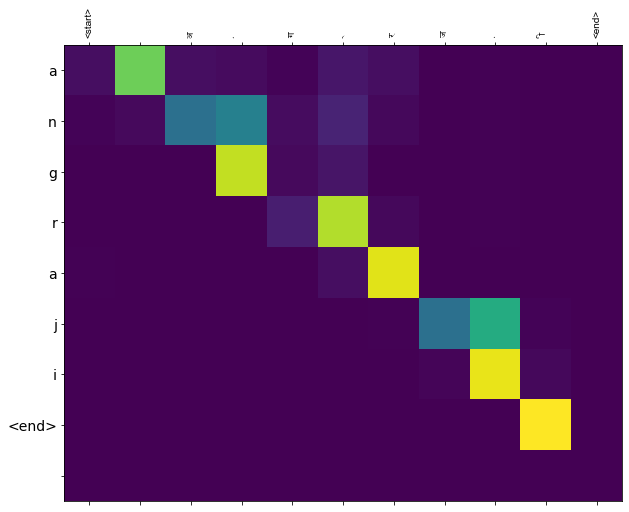

In [31]:
translate(input_texts[10])

In [25]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
data_path = "/content/drive/My Drive/lexicons/hi.translit.sampled.test.tsv"
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    input_text = "\t" + input_text + " " + "\n" 
    target_text = "\t" + target_text + " " + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)

In [26]:
  print(len(input_texts[0]))
  for sentence in input_texts[:10]:
    result, sentence, attention_plot = evaluate(sentence)
    print('-')
    print('Input sentence: 	', sentence)
    print('Decoded sentence: ', result)
    print('\n')

6
-
Input sentence: 	 <start>  अ ं क <end>
Decoded sentence:  a n k <end> 


-
Input sentence: 	 <start>  अ ं क <end>
Decoded sentence:  a n k <end> 


-
Input sentence: 	 <start>  अ ं क ि त <end>
Decoded sentence:  a n k i t <end> 


-
Input sentence: 	 <start>  अ ं क ो ं <end>
Decoded sentence:  a n k o n <end> 


-
Input sentence: 	 <start>  अ ं क ो ं <end>
Decoded sentence:  a n k o n <end> 


-
Input sentence: 	 <start>  अ ं क ो ं <end>
Decoded sentence:  a n k o n <end> 


-
Input sentence: 	 <start>  अ ं क ो र <end>
Decoded sentence:  a n k o r e <end> 


-
Input sentence: 	 <start>  अ ं क ो र <end>
Decoded sentence:  a n k o r e <end> 


-
Input sentence: 	 <start>  अ ं ग ा र क <end>
Decoded sentence:  a n g a r k <end> 


-
Input sentence: 	 <start>  अ ं ग ा र क <end>
Decoded sentence:  a n g a r k <end> 


